<a href="https://colab.research.google.com/github/smannan/LIFXBulbAnalysis/blob/main/SmartBulbDataExploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Analyze brightness for Influx light bulbs

1.   Input data frame should have 3 columns: bulb id, timestamp, and value
2.   Supported values are power or brighness
3.   Brightness value should be a floating point
4.   Power should be ON or OFF



In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd

from datetime import datetime
from dateutil.parser import parse

In [2]:
MAX_TEMP = 2700.0 # (in Kelvin) 4,400 Farenheit
MIN_TEMP = 0.0 # (in Kelvin)
MAX_LUMENS = 650 # (lumens)
MAX_WATTS = 8.5
LUMENS_PER_WATT = MAX_LUMENS / MAX_WATTS # ~76.5

In [3]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as dates

def plot_hist(bulb_df):
  fig, ax = plt.subplots(figsize=(10, 5))
  ax.hist(bulb_df['value'], bins=25)
  plt.show()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
def drop_seconds_from_timestamp(df):
  bulb_data['timestamp'] = pd.to_datetime(bulb_data['timestamp'])
  bulb_data['timestamp'] = bulb_data['timestamp'].dt.strftime('%Y-%m-%d %H:%M')
  bulb_data['timestamp'] = pd.to_datetime(bulb_data['timestamp'])

In [6]:
# brightness is measured in percentage of lumens used
def scale_brightness(df):
  df['brightness'] = df['brightness'] * MAX_LUMENS

In [7]:
filename = '/content/drive/Shared drives/CMPE295B/ProcessedBulbData/smart_bulb_data_from_influx_2021-08-26-13_46_2021-09-20-21_29.csv'
bulb_data = pd.read_csv(filename, infer_datetime_format = True)
drop_seconds_from_timestamp(bulb_data)
scale_brightness(bulb_data)
bulb_data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [8]:
bulb_data.head()

,timestamp,id,brightness,kelvin
0,2021-08-26 13:46:00,d073d55df12f,650.000,2700
1,2021-08-26 13:47:00,d073d55df12f,650.000,2700
2,2021-08-26 13:57:00,d073d55df12f,456.365,2700
3,2021-08-26 13:58:00,d073d55df12f,456.365,2700
4,2021-08-26 13:59:00,d073d55df12f,456.365,2700


In [9]:
bulb_data['brightness'].describe()

count    9275.000000
mean      546.775683
std       108.863989
min         0.000000
25%       541.905000
50%       541.905000
75%       645.515000
max       650.000000
Name: brightness, dtype: float64

In [10]:
bulb_data['kelvin'].describe()

count    9275.000000
mean     2750.059299
std       246.945425
min         0.000000
25%      2700.000000
50%      2700.000000
75%      2700.000000
max      3500.000000
Name: kelvin, dtype: float64

In [11]:
# group by light bulb id and sum the number of missing data for each bulb
bulb_data.groupby(['id']).agg({
    'brightness': lambda x: x.isnull().sum(),
    'kelvin': lambda x: x.isnull().sum(),
    'timestamp': lambda x: x.isnull().sum(),
    'id': lambda x: x.isnull().sum()
})

,brightness,kelvin,timestamp,id
id,,,,
d073d55df12f,0.0,0,0,0
d073d55e535c,0.0,0,0,0


In [12]:
def fill_missing_data(bulb_data):
  bulb_data_complete = bulb_data.copy()

  # where brightness > 0.5 and kelvin = null, set kelvin to max temp
  bulb_data_complete.loc[bulb_data_complete['brightness'] >= 0.5, 'kelvin'] = \
    bulb_data_complete.loc[bulb_data_complete['brightness'] >= 0.5, 'kelvin'].fillna(bulb_data_complete['kelvin'].max())

  # where brightness = 0 and kelvin = null, set kelvin to min temp
  bulb_data_complete.loc[bulb_data_complete['brightness'] < 0.5, 'kelvin'] = \
    bulb_data_complete.loc[bulb_data_complete['brightness'] < 0.5, 'kelvin'].fillna(bulb_data_complete['kelvin'].min())

  # where kelvin is MAX_TEMP and brightness = null, set brightness to max
  bulb_data_complete.loc[bulb_data_complete['kelvin'] == MAX_TEMP, 'brightness'] = \
    bulb_data_complete.loc[bulb_data_complete['kelvin'] == MAX_TEMP, 'brightness'].fillna(bulb_data_complete['brightness'].max())

  # where kelvin is MIN_TEMP and brightness = null, set brightness to min
  bulb_data_complete.loc[bulb_data_complete['kelvin'] == MIN_TEMP, 'brightness'] = \
    bulb_data_complete.loc[bulb_data_complete['kelvin'] == MIN_TEMP, 'brightness'].fillna(bulb_data_complete['brightness'].min())

  return bulb_data_complete

### Fill in missing brightness and Kelvin values
- Some temperature readings don't have a brightness reading and vice versa?

In [13]:
bulb_data_complete = fill_missing_data(bulb_data)
bulb_data_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9275 entries, 0 to 9274
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   timestamp   9275 non-null   datetime64[ns]
 1   id          9275 non-null   object        
 2   brightness  9275 non-null   float64       
 3   kelvin      9275 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 290.0+ KB


In [14]:
def find_time_interval_gaps(bulb_df, interval=1.0):
  times = bulb_df['timestamp'].tolist()
  start_time = times[0]
  diffs = []

  for timestamp in times:
    diff_in_minutes = (timestamp - start_time).total_seconds() / 60

    if (diff_in_minutes > interval):
      diffs.append(diff_in_minutes)

    start_time = timestamp

  if (diffs):
    print ('# of intervals > 1 min = {0}. Max diff = {1}, Min diff = {2}, Avg diff = {3}'.format(
      len(diffs), max(diffs), min(diffs), sum(diffs) / len(diffs)))
  
  return diffs

In [15]:
def analyze_df_for_bulb(bulb_df):
  print('start time', bulb_df['timestamp'].min(), 'end time', bulb_df['timestamp'].max())

  fig, axs = plt.subplots(2)
  fig.suptitle('Brigthness (1) and Temp (2)')
  axs[0].plot(bulb_df['timestamp'], bulb_df['brightness'])
  axs[1].plot(bulb_df['timestamp'], bulb_df['kelvin'])
  plt.gcf().autofmt_xdate()

  find_time_interval_gaps(bulb_df)

### Plot brightness and temp over time

start time 2021-08-26 13:46:00 end time 2021-09-20 21:29:00
# of intervals > 1 min = 23. Max diff = 7034.0, Min diff = 2.0, Avg diff = 1341.608695652174


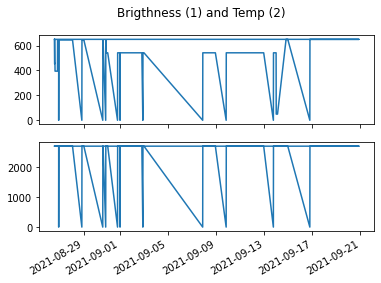

In [16]:
analyze_df_for_bulb(bulb_data_complete.loc[bulb_data_complete['id'] == 'd073d55df12f'])

In [19]:
def fill_in_missing_times(bulb_data, id):
  light_df = bulb_data.loc[bulb_data['id'] == id].drop_duplicates(subset=['timestamp'])
  r = pd.date_range(start=light_df.timestamp.min(), end=light_df.timestamp.max(), freq='1min')
  reindexed = light_df.set_index('timestamp').reindex(r).rename_axis('timestamp').reset_index()

  reindexed['brightness'].fillna(reindexed['brightness'].min(), inplace=True)
  reindexed['kelvin'].fillna(reindexed['kelvin'].min(), inplace=True)
  reindexed['id'].fillna(id, inplace=True)

  return reindexed

In [20]:
light_df = fill_in_missing_times(bulb_data_complete, 'd073d55df12f')
light_df.head()

,timestamp,id,brightness,kelvin
0,2021-08-26 13:46:00,d073d55df12f,650.0,2700.0
1,2021-08-26 13:47:00,d073d55df12f,650.0,2700.0
2,2021-08-26 13:48:00,d073d55df12f,650.0,2700.0
3,2021-08-26 13:49:00,d073d55df12f,650.0,2700.0
4,2021-08-26 13:50:00,d073d55df12f,650.0,2700.0


### Reindex dataframe and fill missing time intervals
- When the light bulbs were off

start time 2021-08-26 13:46:00 end time 2021-09-20 21:29:00


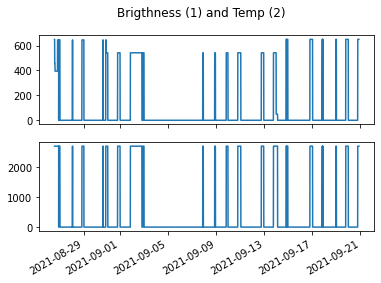

In [21]:
analyze_df_for_bulb(light_df)

In [22]:
def range_brightness(brightness):
  if brightness <= 0.5:
    return 0
  else:
    return 1

In [23]:
def brightness_to_category(df):
  df['brightness'] = df['brightness'].apply(lambda value: range_brightness(value))

In [24]:
brightness_to_category(light_df)

In [25]:
from pytz import timezone
import pytz
import datetime

### Plot intervals usage based on state change in the bulb (ON to OFF or vice versa)
def get_power_intervals(bulb_df, col):
  intervals = []
  cycle = bulb_df[col][0]
  start = bulb_df['timestamp'][0]
  current_timezone = pytz.timezone('US/Pacific')

  for value, timestamp in zip(bulb_df[col][1:], bulb_df['timestamp'][1:]):
    if value != cycle:
      duration = timestamp - start
      duration = round(duration.total_seconds() / 60 / 60, 2)

      intervals.append({ 'start': current_timezone.localize(start).strftime('%m/%d/%Y %H:%M:%S %Z'),
                         'end': current_timezone.localize(timestamp).strftime('%m/%d/%Y %H:%M:%S %Z'),
                         'from': cycle,
                         'to': value,
                         'duration (hours)': duration})
      cycle = value
      start = timestamp

  df = pd.DataFrame(intervals)
  return df

In [26]:
interval_df = get_power_intervals(light_df, 'brightness')

In [27]:
interval_df

,start,end,from,to,duration (hours)
0,08/26/2021 13:46:00 PDT,08/26/2021 22:02:00 PDT,1,0,8.27
1,08/26/2021 22:02:00 PDT,08/26/2021 22:03:00 PDT,0,1,0.02
2,08/26/2021 22:03:00 PDT,08/27/2021 00:25:00 PDT,1,0,2.37
3,08/27/2021 00:25:00 PDT,08/28/2021 01:31:00 PDT,0,1,25.10
4,08/28/2021 01:31:00 PDT,08/28/2021 01:41:00 PDT,1,0,0.17
5,08/28/2021 01:41:00 PDT,08/28/2021 20:18:00 PDT,0,1,18.62
6,08/28/2021 20:18:00 PDT,08/29/2021 00:17:00 PDT,1,0,3.98
7,08/29/2021 00:17:00 PDT,08/30/2021 14:03:00 PDT,0,1,37.77
8,08/30/2021 14:03:00 PDT,08/30/2021 14:40:00 PDT,1,0,0.62
9,08/30/2021 14:40:00 PDT,08/30/2021 19:55:00 PDT,0,1,5.25


In [28]:
def lumens_to_watts(lumens):
  if lumens > 0.5:
    return MAX_WATTS
  else:
    return 0

def add_watts(bulb_data):
  bulb_data['watts'] = bulb_data['brightness'].apply(lambda x: lumens_to_watts(x))

In [29]:
add_watts(light_df)

### Convert timestamp to hours and sum total watt usage

In [30]:
def drop_seconds_from_timestamp(bulb_data):
  bulb_data['timestamp'] = bulb_data['timestamp'].dt.strftime('%Y-%m-%d %H')
  bulb_data['timestamp'] = pd.to_datetime(bulb_data['timestamp'])

In [31]:
light_df_hourly = light_df.copy()
drop_seconds_from_timestamp(light_df_hourly)
light_df_hourly_aggd = light_df_hourly.groupby(['timestamp']).agg({
    'brightness': 'mean',
    'kelvin': 'mean',
    'watts': 'sum'
  })
# convert watts per hour to kilowatts per hour
light_df_hourly_aggd['watts'] = light_df_hourly_aggd['watts'] / 1000
light_df_hourly_aggd.rename(columns={'watts': 'kWH'}, inplace=True)
light_df_hourly_aggd['kWH'].describe()

count    609.000000
mean       0.078552
std        0.176214
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.510000
Name: kWH, dtype: float64

In [32]:
light_df_hourly_aggd.reset_index(inplace=True)

In [33]:
get_power_intervals(light_df_hourly_aggd, 'kWH')

,start,end,from,to,duration (hours)
0,08/26/2021 13:00:00 PDT,08/26/2021 14:00:00 PDT,0.1190,0.5100,1.0
1,08/26/2021 14:00:00 PDT,08/26/2021 22:00:00 PDT,0.5100,0.5015,8.0
2,08/26/2021 22:00:00 PDT,08/26/2021 23:00:00 PDT,0.5015,0.5100,1.0
3,08/26/2021 23:00:00 PDT,08/27/2021 00:00:00 PDT,0.5100,0.2125,1.0
4,08/27/2021 00:00:00 PDT,08/27/2021 01:00:00 PDT,0.2125,0.0000,1.0
...,...,...,...,...,...
69,09/19/2021 19:00:00 PDT,09/19/2021 20:00:00 PDT,0.4675,0.5100,1.0
70,09/19/2021 20:00:00 PDT,09/20/2021 00:00:00 PDT,0.5100,0.1105,4.0
71,09/20/2021 00:00:00 PDT,09/20/2021 01:00:00 PDT,0.1105,0.0000,1.0
72,09/20/2021 01:00:00 PDT,09/20/2021 19:00:00 PDT,0.0000,0.5100,18.0


In [34]:
light_df_hourly_aggd.head()
print (len(light_df_hourly_aggd))
light_df_hourly_aggd.to_csv('{0}_{1}_hourly.csv'.format(light_df_hourly_aggd['timestamp'].min(), light_df_hourly_aggd['timestamp'].max()))

609


https://www.energy.gov/energysaver/lighting-choices-save-you-money
- Households spend 15% on lighting and can save 225$ per year by switching to LED bulbs 

https://www.energy.gov/energysaver/led-lighting
- LED bulbs release 80% of their energy as heat

Bulb energy useage
- Watt = joules per second, how much energy it takes to power the bulb
- Lumens = how much brightness the bulb provides
more energy efficient bulbs have a higher lumens per watt ratio
- Watts are usually used for individual bulbs and KW for large-scale capacity
- KWh = energy usage over time. Multiple watts by hours used. Energy pricing is based on KWh or usage time

### Pre-processing
1. Any brightness > 0.5 is considered ON
2. Multiple missing time gaps - these were filled with a value of OFF
3. Original dataset did not have any missing values
4. Original length ~2.8k, after processing ~19k
5. Some brightness value did not have a correpsonding temp and vice versa, missing values were filled in via max or min brightness / temp
6. No straightforward way to calculate watts from temperature and brightness, can we assume if the light is on it's using the total wattage available? What if it's dimmed?

### Light usage patterns
- Use the lights mostly at night time from 8 PM to 2 AM
- Working late might forget to turn on lights
- Sometimes will use light from the TV, one person will watch tv almost every day
- Daily routines are mostly the same but there may be seasonal changes based on daylight savings
- 2-3 people living in the house
- Lights are in the living room where everyone uses it

### Results
1. Lights were on from Sept 2nd to Sept 3rd?
- Part of an experiment and intentially left on

2. Lights were off from Sept 3rd to Sept 8th (participants came home on the 6th)
3. Lights were also off for most of the day on Sept 8th to 9th